<a href="https://colab.research.google.com/github/vskarich2/cs231n_final/blob/main/PVT_ModelNet40_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point-Voxel Transformer on ModelNet40
This Colab notebook sets up the pre-trained PVT model and classifies ModelNet40 samples, with visualization of 3D objects.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
import os
import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "7.5" # This is for T4 GPU only, other GPUs have different numbers and you must change this.
userdata.get('HF_TOKEN')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

# Clone the repository and install dependencies
!git clone https://github.com/vskarich2/PVT_forked.git
%cd PVT_forked
!pip install --upgrade pip
!pip install -r requirements.txt
!apt-get update -qq && apt-get install -qq -y ninja-build
!pip install --quiet kaggle ninja

Mounted at /content/drive
Cloning into 'PVT_forked'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 163 (delta 23), reused 25 (delta 15), pack-reused 126 (from 1)
Receiving objects: 100% (163/163), 65.31 MiB | 50.62 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/PVT_forked
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 186.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 194.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 43.4 MB/

In [2]:
!kaggle datasets download -d chenxaoyu/modelnet-normal-resampled \
    -p /content/PVT_forked/data --unzip

Dataset URL: https://www.kaggle.com/datasets/chenxaoyu/modelnet-normal-resampled
License(s): unknown
 98% 1.62G/1.65G [00:02<00:00, 425MB/s]
100% 1.65G/1.65G [00:02<00:00, 704MB/s]


airplane   cup		 lamp			     night_stand  table
bathtub    curtain	 laptop			     person	  tent
bed	   desk		 mantel			     piano	  toilet
bench	   door		 modelnet10_shape_names.txt  plant	  tv_stand
bookshelf  dresser	 modelnet10_test.txt	     radio	  vase
bottle	   filelist.txt  modelnet10_train.txt	     range_hood   wardrobe
bowl	   flower_pot	 modelnet40_shape_names.txt  sink	  xbox
car	   glass_box	 modelnet40_test.txt	     sofa
chair	   guitar	 modelnet40_train.txt	     stairs
cone	   keyboard	 monitor		     stool


In [100]:
# !mv /content/PVT_forked/data/modelnet40_normal_resampled /content/PVT_forked/data/modelnet40_normal_resampled_temp
# !mkdir -p /content/PVT_forked/data/modelnet40_normal_resampled
# !mv /content/PVT_forked/data/modelnet40_normal_resampled_temp/modelnet40_shape_names.txt /content/PVT_forked/data/modelnet40_normal_resampled
# !mv /content/PVT_forked/data/modelnet40_normal_resampled_temp/modelnet40_train.txt /content/PVT_forked/data/modelnet40_normal_resampled
# !mv /content/PVT_forked/data/modelnet40_normal_resampled_temp/modelnet40_test.txt /content/PVT_forked/data/modelnet40_normal_resampled

In [101]:

# %cd /content/PVT_forked/data/modelnet40_normal_resampled
# !wget -q http://modelnet.cs.princeton.edu/ModelNet40.zip -O ModelNet40.zip
# !unzip -q ModelNet40.zip
# !mv ModelNet40/* .
# !rm -rf ModelNet40 ModelNet40.zip
# %cd /content/PVT_forked
# !ls

/content/PVT_forked/data/modelnet40_normal_resampled
/content/PVT_forked
checkpoints	kitti_meters   main_part_seg.py  provider.py
data		LICENSE        main_semseg.py	 README.md
data.py		main_cls.py    model		 requirements.txt
kitti_datasets	main_kitti.py  modules		 util.py


In [23]:
%cd  /content/PVT_forked/data
#!sudo apt-get update && sudo apt-get install -y tree
!tree -L 2

/content/PVT_forked/data
.
├── kitti
│   └── frustum
├── modelnet40_normal_resampled
│   ├── airplane
│   ├── bathtub
│   ├── bed
│   ├── bench
│   ├── bookshelf
│   ├── bottle
│   ├── bowl
│   ├── car
│   ├── chair
│   ├── cone
│   ├── cup
│   ├── curtain
│   ├── desk
│   ├── door
│   ├── dresser
│   ├── filelist.txt
│   ├── flower_pot
│   ├── glass_box
│   ├── guitar
│   ├── keyboard
│   ├── lamp
│   ├── laptop
│   ├── mantel
│   ├── modelnet10_shape_names.txt
│   ├── modelnet10_test.txt
│   ├── modelnet10_train.txt
│   ├── modelnet40_shape_names.txt
│   ├── modelnet40_test.txt
│   ├── modelnet40_train.txt
│   ├── monitor
│   ├── night_stand
│   ├── person
│   ├── piano
│   ├── plant
│   ├── radio
│   ├── range_hood
│   ├── sink
│   ├── sofa
│   ├── stairs
│   ├── stool
│   ├── table
│   ├── tent
│   ├── toilet
│   ├── tv_stand
│   ├── vase
│   ├── wardrobe
│   └── xbox
└── s3dis
    └── prepare_data.py

44 directories, 8 files


In [16]:
# Evaluate pretrained model on the test set (batch size 8)
!python /content/PVT_forked/main_cls.py --exp_name cls --num_points 1024 --use_sgd True --eval True --model_path checkpoints/cls/model.t7 --test_batch_size 8

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
cp: cannot stat 'main.py': No such file or directory
Namespace(exp_name='cls', model='pvt', dataset='modelnet40', batch_size=32, test_batch_size=8, epochs=200, use_sgd=True, lr=0.001, momentum=0.9, no_cuda=False, seed=1, eval=True, num_points=1024, dropout=0.5, model_path='checkpoints/cls/model.t7')
Using GPU : 0 from 1 devices
The size of test data is 2468
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Test :: test acc: 0.938817, test avg acc: 0.913

['bed_0494', 'bookshelf_0483', 'plant_0160']
bed_0494
Visualizing train sample: bed/0494 (10000 points)


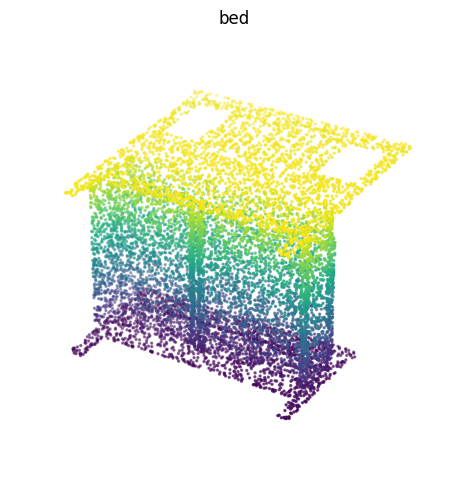

bookshelf_0483
Visualizing train sample: bookshelf/0483 (10000 points)


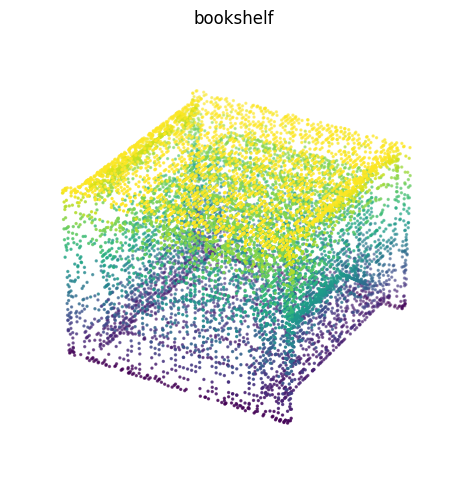

plant_0160
Visualizing train sample: plant/0160 (10000 points)


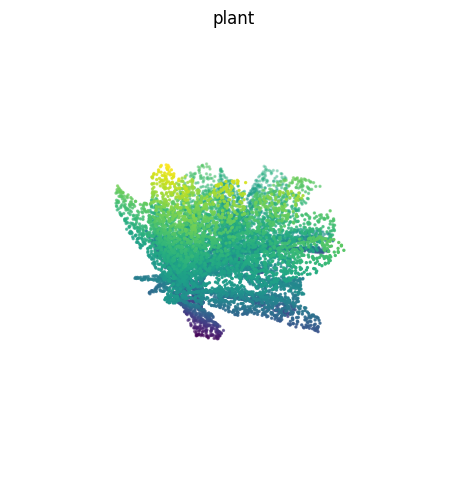

In [33]:
# visualize_train_samples.py

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def load_point_cloud(path):
    """
    Load a point cloud from .txt or .dat (Nx3 or Nx6) and return an (N,3) numpy array.
    """
    data = np.loadtxt(path, delimiter=',')
    # if normals are present, only take the XYZ columns
    return data[:, :3] if data.shape[1] >= 3 else data

def plot_cloud(points, title=None):
    """
    Scatter-plot a set of 3D points with matplotlib.
    """
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               c=points[:, 2], cmap='viridis', s=2, depthshade=True)
    ax.set_axis_off()
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

def main(
    data_root='/content/PVT_forked/data/modelnet40_normal_resampled',
    split_file='modelnet40_train.txt',
    n_samples=3,
    seed=67
):
    # build full path to the train split file
    split_path = os.path.join(data_root, split_file)
    with open(split_path, 'r') as f:
        # each line is like "chair/chair_0001"
        examples = [line.strip() for line in f if line.strip()]

    random.seed(seed)
    picks = random.sample(examples, min(n_samples, len(examples)))
    print(picks)
    for rel in picks:
        print(rel)
        category, basename = rel.split('_')
        # prefer the .txt point-cloud; fall back to .dat if missing
        txt_path = os.path.join(data_root, category, rel + '.txt')

        if os.path.exists(txt_path):
            pts = load_point_cloud(txt_path)
        else:
            print(f"❌ Missing {txt_path}, skipping.")
            continue

        print(f"Visualizing train sample: {category}/{basename} ({pts.shape[0]} points)")
        plot_cloud(pts, title=category)


main()
